# Assignment 3 – Topic Modeling and Clustering for Online Social Media Data

*Due: Friday January 12 at 14:00 CET*

In the third assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use topic modeling and clustering to identify topics in online social media data. The objectives of this assignment are:
- understand and process the text data
- use the clustering algorithm to determine clusters in real-life data
- use the Latent Dirichlet Allocation algorithm to identify discussed topics in real-life text data 
- use the visualization tools to validate the results of unsupervised learning and interpret your findings
- reflect on the difference between two type of unsupervised learning algorithms

In this assignment, you are going to discover the different ‘topics’ from a real social media text dataset. The project is divided into two parts (4 subtasks):

- The first part contains data processing (1.1) and feature extraction (1.2) from the raw text data.
- In the second part, you will implement two methods (2.1), a topic modeling method and a clustering method, to identify topics from the processed data. Then, the evaluation will be done by using visualization tools (2.2). 

Provided files:
- The dataset: data/raw_data.txt
- A tutorial notebook showcases some packages you could use for this assignment (optional): Ass3_tutorial.ipynb
- Some sample visualization codes for interpreting the topic results: viz_example.ipynb

In [1]:
import io

# TODO: import the packages
import spacy
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


RANDOM_SEED = 42

In [2]:
# load spacy's nl_core_news_sm language model
nlp = spacy.load("nl_core_news_sm")

 ## Dataset:
 The data used in this assignment is Dutch text data. We collected the COVID-19 crisis related messages from online social media (Twitter) from January to November 2021. Then, a subset of raw tweets was randomly sampled. In total, our dataset includes the text data of about 100K messages. **To protect the data privacy, please only use this dataset within the course.**

 ## 0. Before you start the Project: 
 The provided messages in the raw dataset were collected based on 10 different themes that relate to the COVID-19 crisis. Here is a list of all themes:
 -	Lockdown
 -	Face mask
 -	Social distancing
 -	Loneliness
 -	Happiness
 -	Vaccine
 -	Testing
 -  Curfew
 -  Covid entry pass
 -  Work from home

Before starting your project, you need to first filter the messages (all messages are in Dutch) and use the messages belonging to only one theme for the topic identification. 
 
If you have submitted the theme preference, you can skip the following paragraph.

*Please notice that there will be maximum two teams working on a same theme. In this way, we hope that each group will develop their own dataset and come up with interesting results.*

 ## 1.1 Data Processing
 In the first part of the assignment, please first filter the messages and use the messages belonging to your allocated theme for the identification of topics. For that you will need to:
 -	Design your query (e.g. a regular expression or a set of keywords) and filter the related messages for your allocated theme. 
 -	Clean your filtered messages and preprocess them into the right representation. Please refer to the text data pre-processing and representation methods discussed in the lecture. You may use some of the recommended packages for text data preprocessing and representation.

In [3]:
# read the data

def phase0_open_txt_stream(filename):
    return io.open(filename, "r", encoding="utf-8")

def get_data(max = -1, filtered = False):
    pipe = phase0_open_txt_stream("../others/data/" + ("raw_data.txt" if not filtered else "filtered_data.txt"))
    data = []
    cont = 0

    while (cont != max):
        try: 
            raw_text = next(pipe).replace("\\n", "")
        except StopIteration:
            # break if end of file is reached
            pipe.close()
            break

        # remove ill formatted text
        url_pattern = "http(s?)://.+( ?)"
        html_pattern = "&.*;"
        raw_text = re.sub(url_pattern, " ", raw_text)
        raw_text = re.sub(html_pattern, " ", raw_text)
        raw_text = raw_text.replace(".", " ")\
                           .replace("?", " ")\
                           .replace("(", " ")\
                           .replace(")", " ")\
                           .replace(",", " ")\
                           .replace("!", " ")
        
        sentence = nlp(raw_text)
        data.append(sentence)
        cont += 1
    pipe.close()
    return data

data = get_data(1000, filtered= True)

In [4]:
# TODO: filter the related messages
# TOPIC : Loneliness
topic_words = [
    "alleen",         # alone
    "geïsoleerd",     # isolated
    "isolatie",       # isolation
    "kluizenaar",     # hermit
    "eenzaamheid",    # solitude
    "eenzaam",        # lonely
    "virtueel",       # virtual
    "knuffel",        # hug
    "thuis",          # at home
    # "avondklok",      # curfew
]

data_filtered = []
for sentence in data:
    if any(token.lemma_.lower() in topic_words for token in sentence):
        data_filtered.append(sentence)

print(f"filtered {len(data_filtered)} messages related to loneliness")

# store filtered raw data
# with open("filtered_raw_data.txt", "w", encoding="utf-8") as _file:
#     _file.writelines([sentence.text for sentence in data_filtered], )

filtered 1000 messages related to loneliness


In [5]:
# TODO: clean and preprocess the messages
#  - remove URL, mentions, numbers, hashtags, ?emojis?
url_pattern = "^http(s?)://.+"
mention_pattern = "^@.+"
number_pattern = "(\d+,\d+)|(\d+\.\d+)|(\d+%)|(^\d+.*)|(\+\d+)"
emoji_pattern = "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002000-\U000020ff]"

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

def match_pattern(pattern, text):
    match = re.match(pattern, text)
    return bool(match)

def generate_hash(sentence):
    text = "".join([token.text for token in sentence])
    return hash(text)


data_processed = {}
sentence_id = 0
for sentence in data_filtered:
    sentence_processed = []

    for token in sentence:

        #  - remove URL, mentions, emojis, 
        if match_pattern(url_pattern, token.text) or \
           match_pattern(mention_pattern, token.text) or \
           match_pattern(emoji_pattern, token.text):
            continue
        
        # - remove numbers, punctuation 
        if token.is_punct or token.is_space or token.is_digit or \
           match_pattern(number_pattern, token.text) :
            continue
        
        #  - Stopping
        if token.is_stop:
            continue

        if token.pos_ not in allowed_postags:
            continue

        sentence_processed.append(token)
    
    # add preprocessed sentence in a way that prevents duplicate messages
    key = generate_hash(sentence_processed)
    if key not in data_processed and len(sentence_processed) >0:
        data_processed[key] = {
            "id" : sentence_id,
            "sentence" : sentence,
            "bow": sentence_processed,
            #  - Stemming & Lemmatization
            "lemmas" : [token.lemma_.lower() for token in sentence_processed]
        }
        sentence_id += 1

print(f"preprocessed {len(data_processed)} unique messages related to loneliness")

preprocessed 778 unique messages related to loneliness


In [6]:
# TODO: represent the messages into formats that can be used in clustering or LDA algorithms (you may need different represention for two algorithms)
# generate document term frequency matrix that is going to be used by LDA
documents = [" ".join(sentence["lemmas"]) for sentence in data_processed.values()]

dutch_stopwords = [
    'aan', 'als', 'bij', 'dan', 'dat', 'die', 'dit', 'een', 'en', 'er', 'het',
    'hij', 'hoe', 'hun', 'ik', 'in', 'is', 'je', 'kan', 'maar', 'met', 'mij', 'niet', 'nog',
    'nu', 'of', 'ons', 'ook', 'te', 'tot', 'uit', 'van', 'voor', 'was', 'wat',
    'we', 'wel', 'wij', 'zal', 'ze', 'zei', 'zelf', 'zich', 'zo', 'zij'
]

vectorizer = CountVectorizer(stop_words=dutch_stopwords)
dtf_matrix = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()
dtf_df = pd.DataFrame(dtf_matrix.toarray(), columns=terms)



# generate term frequency-inverse document frequency matrix that is going to be used by kmeans
tfid_vectorizer = TfidfVectorizer(stop_words=dutch_stopwords)

tf_df_matrix = tfid_vectorizer.fit_transform(documents) 
tf_df_terms = tfid_vectorizer.get_feature_names_out()
tf_df_df = pd.DataFrame(tf_df_matrix.toarray(), columns=terms)

# spacy vector representation for tokens
for entry in data_processed.values():
    entry["doc_vector"] = np.mean([token.vector for token in entry["bow"]], axis=0) 

word_embeddings_df = pd.DataFrame.from_dict(data_processed, orient='index')
word_embeddings_df = word_embeddings_df.drop(['bow', 'lemmas'], axis="columns")

 ## 1.2 Exploratory Data Analysis
 After preprocessing the data, create at least 2 figures or tables that help you understand the data.

 While exploring the data, you may also think about questions such as:
 - Can you spot any differences between Twitter data and usual text data?
 - Does your exploration reveal some issues that would make it difficult to interpret the topics?
 - Can you improve the data by adding additional preprocessing steps?

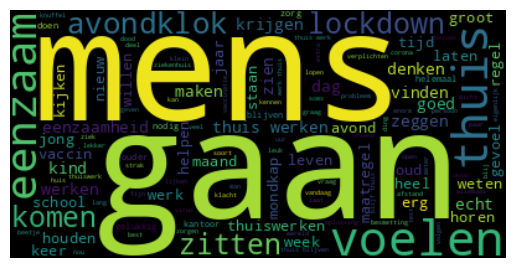

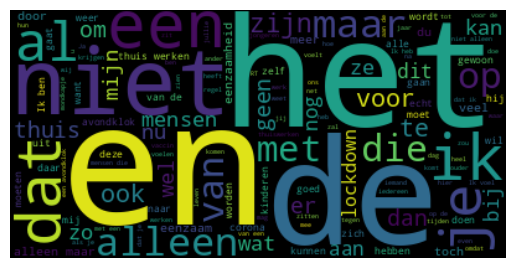

In [7]:
# TODO: plot figure(s)
text_processed = ""
text_original = ""
for key in data_processed:
    entry = data_processed[key]
    text_processed += " " + " ".join(entry["lemmas"])
    text_original += " " + " ".join([token.text for token in entry["sentence"]])

# Create and generate a word cloud image:
processed_wordcloud = WordCloud().generate(text_processed)
original_wordcloud = WordCloud().generate(text_original)

# Display the generated image:
plt.imshow(processed_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imshow(original_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
word_embeddings_df

,id,sentence,doc_vector
-5466928951036792056,0,"(Gelukkig, en, gezond, 2021, toegewenst, , me...","[0.315654, 1.7471596, 1.3212625, -0.27366182, ..."
-5043019286561016092,1,"(@thesarge671, @LodewijkA, Ik, heb, mij, , bi...","[-0.7463156, 0.3303836, 1.5430362, -0.5114082,..."
-47644323777774554,2,"(@LadyDJane, _, Wat, je, zegt, inderdaad, , I...","[0.9220417, 3.3449252, 0.1479228, -1.0507272, ..."
-1613215671070095793,3,"(We, gaan, een, wat, koudere, periode, tegemoe...","[-0.5735621, 1.1777651, 1.3168204, 0.36977494,..."
-2503570386604841178,4,"(ethischer, , beter, voor, die, zielige, aort...","[-2.9434156, 0.5936578, -0.9678616, 0.49360165..."
...,...,...,...
-7160758002117241746,773,"(RT, @ReintJanRenes, :, Stuk, leuker, dan, de,...","[-0.74275696, 3.217053, 0.032105036, -1.543651..."
-7841008753862190749,774,"(Heeft, vaker, nieuw, nr, gehad, dus, daar, da...","[-1.0218173, 2.8114052, 0.16594741, 0.6461244,..."
-8226804210891187100,775,"(@levensfilosoof, @MarjanSlob, Er, zijn, drie,...","[-0.42694318, 0.9789664, 1.5050865, -1.647345,..."
-1234115712510576862,776,"(@marcoderksen, Haha, erken, mezelf, niet, dat...","[-0.32161683, 2.4789977, 1.0784471, 0.92320794..."


## 2.1 Topic modelling and clustering
 In the second part of the assignment, you will first:
 -	Implement a Latent Dirichlet Allocation (LDA) algorithm to identify the discussed topics for your theme
 -	Implement a clustering method  to cluster messages into different groups, then represent the topic of each cluster using a bag of words

While implementing the algorithms, you may use the codes from the recommended packages. In the final report, please explain reasons to select the used algorithm/package. 

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def get_term_document_matrix(data_mod = None):
    if  not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        # 100 documents with 35 words each
        return np.random.rand(1000,35)
    if data_mod == 'tmp':
        from sklearn.feature_extraction.text import CountVectorizer
        tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                        lowercase = True,
                                        stop_words = dutch_stopwords,
                                        token_pattern = r'\b[a-zA-Z]{3,}\b',
                                        max_df = 0.5, 
                                        min_df = 10)
        document_term_matrix = tf_vectorizer.fit_transform(data_processed)
        print(document_term_matrix.shape, len(tf_vectorizer.vocabulary_))
        return document_term_matrix, tf_vectorizer
    if data_mod =='processed':
        return dtf_matrix
    
    
def get_word2vector_matrix(data_mod = None):
    if not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        return np.random.rand(3466,4)
    if data_mod == 'processed':
        raise AttributeError("I don't know processed data yet")
        

def get_document2vector_matrix(data_mod = None):
    if not data_mod or data_mod == 'rand':
        np.random.seed(RANDOM_SEED)
        return np.random.rand(1000,4)
    if data_mod == 'processed':
        liofli = [document_components.tolist() for document_components in word_embeddings_df['doc_vector']]
        return  np.array(liofli)

In [10]:
# TODO: topic modeling using the LDA algorithm

dtm_tf = get_term_document_matrix(data_mod='processed')
tf_vectorizer = vectorizer
lda_tf = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)

doc_topic = lda_tf.fit_transform(dtm_tf)

print("document-term matrix shape:", dtm_tf.shape)
print("document-topic shape: ",doc_topic.shape)
print("example document 1:",doc_topic[1])

tf_lda_tf = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)

tf_doc_topic = tf_lda_tf.fit_transform(tf_df_matrix)

print("tf document-term matrix shape:", tf_df_matrix.shape)
print("tf document-topic shape: ",tf_doc_topic.shape)
print("tf example document 1:",tf_doc_topic[1])

document-term matrix shape: (778, 3401)
document-topic shape:  (778, 5)
example document 1: [0.01267363 0.94930602 0.0126459  0.01267099 0.01270345]
tf document-term matrix shape: (778, 3401)
tf document-topic shape:  (778, 5)
tf example document 1: [0.04219543 0.83154822 0.0419774  0.04203897 0.04223998]


#### 2.2 Genism Method


In [11]:
# # Remove rare and common tokens.
# from gensim.corpora import Dictionary
# # Create a dictionary representation of the documents.
# matrix_sentences = [el.split(" ") for el in raw_data]
# dictionary = Dictionary(documents=matrix_sentences)

# # Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
# print(dictionary)

In [12]:
# # Bag-of-words representation of the documents.
# corpus = [dictionary.doc2bow(doc) for doc in matrix_sentences]

In [13]:
# # Train LDA model.
# from gensim.models import LdaModel

# # Set training parameters.
# num_topics = 5
# chunksize = 2000
# passes = 20
# iterations = 400
# eval_every = None  # Don't evaluate model perplexity, takes too much time.

# # Make an index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# model = LdaModel(
#     corpus=corpus,
#     id2word=id2word,
#     chunksize=chunksize,
#     alpha='auto',
#     eta='auto',
#     iterations=iterations,
#     num_topics=num_topics,
#     passes=passes,
#     eval_every=eval_every,
#     random_state=RANDOM_SEED
# )

In [14]:
# import json
# import numpy as np

# def load_R_model(filename):
#     data = {'topic_term_dists': model.get, 
#             'doc_topic_dists': model.theta,
#             'doc_lengths': data_input['doc.length'],
#             'vocab': data_input['vocab'],
#             'term_frequency': data_input['term.frequency']}
#     return data

# movies_model_data = load_R_model('data/movie_reviews_input.json')

# print('Topic-Term shape: %s' % str(np.array(movies_model_data['topic_term_dists']).shape))
# print('Doc-Topic shape: %s' % str(np.array(movies_model_data['doc_topic_dists']).shape))

### Clustering

In [15]:
word_vector_matrx = get_word2vector_matrix(data_mod='rand')
document_vector_matrx = get_document2vector_matrix(data_mod='processed')
word_vector_matrx.shape, document_vector_matrx.shape

((3466, 4), (778, 96))

In [16]:
# TODO: cluster the messages using a clustering algorithm

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

clustrer_labels = kmeans.fit_predict(document_vector_matrx)
clustrer_labels.shape, max(clustrer_labels)
kmeans.cluster_centers_.shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(5, 96)

In [17]:
import pandas as pd

#Embedded as the average of words that is composed of
df = dtf_df
df['cluster'] = clustrer_labels

aggregated_clusters = df.groupby('cluster').sum()
aggregated_clusters

,a25,aaaaaa,aanbevelenswaardig,aanbieden,aanbieder,aanbod,aandacht,aandoen,aandoening,aandringen,...,zwitserland,zwols,zék,zó,zóveel,écht,énigé,ïrriteren,óók,überhaupt
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,1,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,1,0,1,1
3,1,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,2,0,3,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
def print_cluster_eval(X, label):
    print(f"Silhouette Score: {silhouette_score(X, label, metric='cosine')}")
    print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, label)}")
    print(f"Davies Boulding Score: {davies_bouldin_score(X, label)}")

In [19]:
print_cluster_eval(document_vector_matrx, clustrer_labels)

Silhouette Score: 0.10103682674486349
Silhouette Score: 42.0780617453794
Silhouette Score: 3.1617381191883105


 ## 2.2 Results, evaluation and Interpretation 
 
Finally, you will describe, evaluate and interpret your findings from two methods. 

- In the report, you need to describe and discuss the similarity and difference of results from two methods.
- While evaluating the results, human judgment is very important, so visualization techniques are helpful to evaluate the identified topics in an interpreted manner. 
    
1. For evaluating the topic modelling algorithm, please first use the interactive tool **[pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=)** to examine the inter-topic separation of your findings. 

2. For interpreting the identified topics / clusters of both algorithms, we provide example code for several visualization techiques. You can use multiple ones to evaluate your results or come up with visualisations on your own. The files contain examples for how to use the visualisation functions.


In [20]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.031495 -0.085186       1        1  26.390592
2      0.075659  0.018344       2        1  23.436367
0      0.021311  0.086343       3        1  19.318446
4     -0.029364 -0.035526       4        1  16.810333
1     -0.099101  0.016026       5        1  14.044263, topic_info=           Term        Freq       Total Category  logprob  loglift
2710      thuis  214.000000  214.000000  Default  30.0000  30.0000
3241     werken   99.000000   99.000000  Default  29.0000  29.0000
3202       week   25.000000   25.000000  Default  28.0000  28.0000
895        gaan  113.000000  113.000000  Default  27.0000  27.0000
33       aantal   18.000000   18.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
602      denken    4.967368   38.185565   Topic5  -5.6556  -0.0766
1177     houden    4.605468   46.633210   Topic5  -5.7313  -0.3521
174   avondklok    4.596468   71.009849   Topic5  -5.7332  -0.7746
2418     school    4.313456   29.330858   Topic5  -5.7968   0.0461
988      gevoel    4.288966   22.125884   Topic5  -5.8025   0.3223

[391 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
14        5  0.942274  aangeven
18        3  0.896681  aankomen
33        1  0.801088    aantal
33        2  0.106812    aantal
33        3  0.053406    aantal
...     ...       ...       ...
3371      4  0.125202      zorg
3371      5  0.125202      zorg
3372      1  0.533208    zorgen
3372      2  0.088868    zorgen
3372      5  0.355472    zorgen

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

In [21]:
pyLDAvis.lda_model.prepare(tf_lda_tf, tf_df_matrix, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.041336 -0.019618       1        1  23.312593
3      0.007699  0.045546       2        1  22.474046
1     -0.029916 -0.010446       3        1  18.913103
0     -0.011916 -0.007695       4        1  18.522590
4     -0.007203 -0.007787       5        1  16.777668, topic_info=                  Term      Freq      Total Category  logprob  loglift
3202              week  3.000000   3.000000  Default  30.0000  30.0000
567                dag  5.000000   5.000000  Default  29.0000  29.0000
529   coronabesmetting  1.000000   1.000000  Default  28.0000  28.0000
2869            vaccin  2.000000   2.000000  Default  27.0000  27.0000
572              dalen  1.000000   1.000000  Default  26.0000  26.0000
...                ...       ...        ...      ...      ...      ...
1122            helpen  0.615321   2.775383   Topic5  -6.5521   0.2787
3355            zitten  0.727575   6.273411   Topic5  -6.3845  -0.3692
1619         maatregel  0.617106   3.011828   Topic5  -6.5492   0.1999
3079            voelen  0.749349  10.006428   Topic5  -6.3550  -0.8067
174          avondklok  0.673935   7.452304   Topic5  -6.4611  -0.6180

[357 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
33        2  0.370959   aantal
33        3  0.370959   aantal
91        1  0.263310  afstand
91        2  0.263310  afstand
91        4  0.263310  afstand
...     ...       ...      ...
3355      2  0.318806   zitten
3355      3  0.159403   zitten
3355      4  0.159403   zitten
3355      5  0.159403   zitten
3384      5  0.563961    zwaar

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

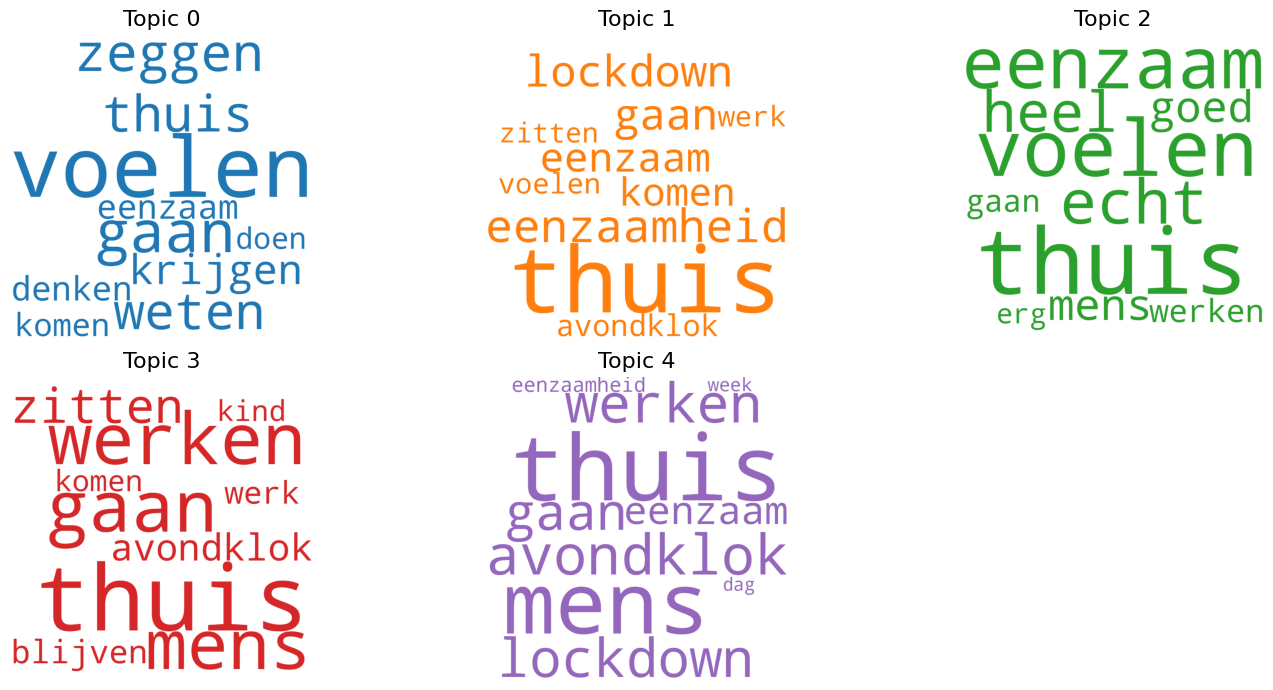

In [22]:
import sys
sys.path.insert(1, '../others')

from viz import show_topic_wordclouds

bag_dimension = 15

top_columns = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).index.tolist(), axis=1)
top_scores = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).values.tolist(), axis=1)
# print(top_columns)
# print(top_scores)

dictionaries = [dict(
                    zip(word, [float(value) for value in top_scores_value])
                    )
                    for word, top_scores_value in zip(top_columns, top_scores)]

nested_dictionary = {i:dictionary for i,dictionary in enumerate(dictionaries)}

topic_id = pd.DataFrame(columns=['topic_id'], data=np.arange(0,nested_dictionary.__len__()))

show_topic_wordclouds(df_dominant_topics=topic_id, topics=nested_dictionary)

In [23]:
word_in_sentences_list = []
sentences = list(map(lambda token: token.text,word_embeddings_df['sentence'].values.tolist()))
for sentence in sentences:
    word_in_sentences_list.extend(list(filter(lambda x: x != "" and x != '\n',sentence.split(" "))))

/Users/lorenzo/coding/ApplicationOfMachineLearning/Assignment3/notebooks/../others/viz.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_word_dominant_topics.loc[df_word_dominant_topics[col_topic_id] == topic_id, 'word'],
/Users/lorenzo/coding/ApplicationOfMachineLearning/Assignment3/notebooks/../others/viz.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_word_dominant_topics.loc[df_word_dominant_topics[col_topic_id] == topic_id, 'word'],
/Users/lorenzo/coding/ApplicationOfMachineLearning/Assignment3/notebooks/../others/viz.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_word_dominant_topics.loc[df_word_dominant_topics[col_topic_id] == topic_id, 'word'],
/Use

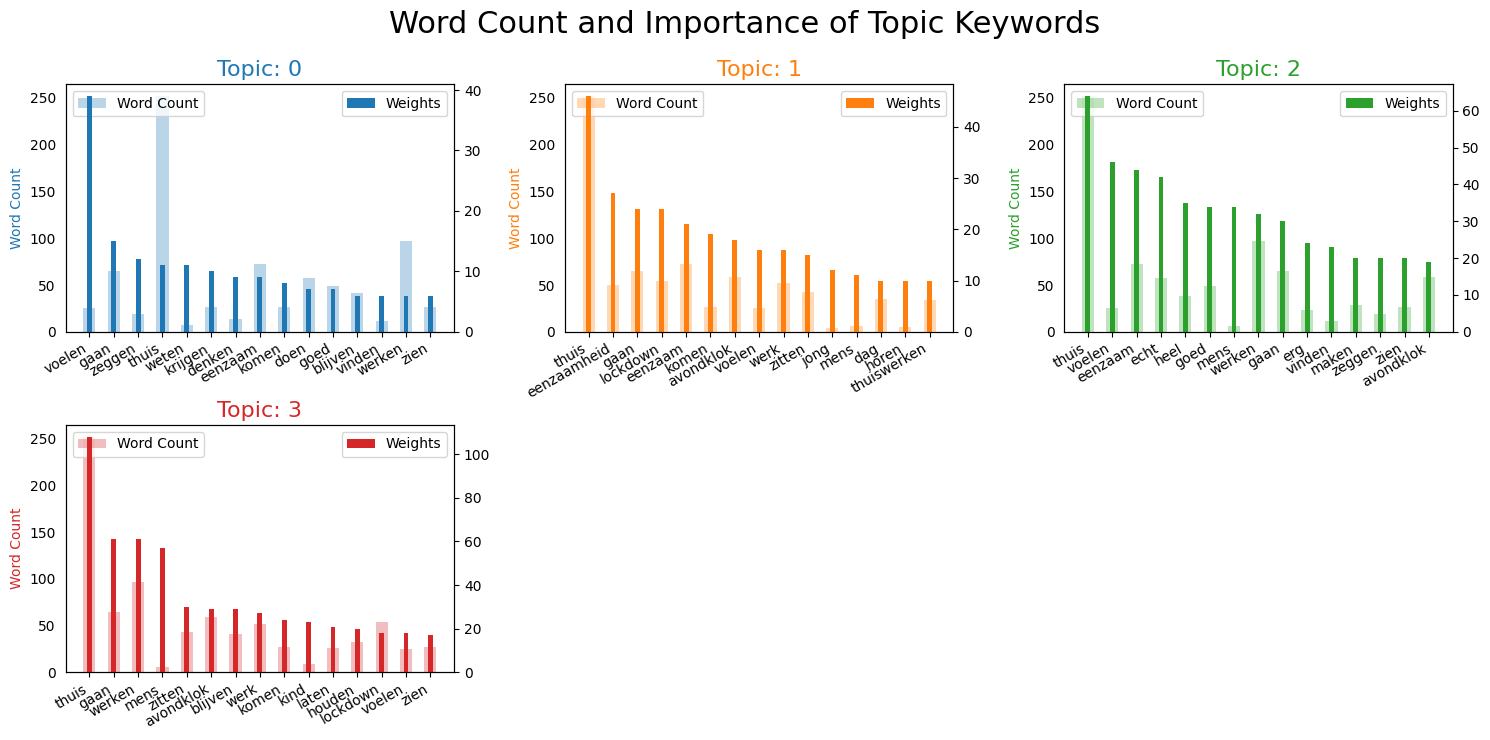

In [24]:
from viz import show_wordcounts_and_topics
show_wordcounts_and_topics(nested_dictionary, words_in_flat_list=word_in_sentences_list)

# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement another clustering algorithm or design your own clustering algorithm. Discuss your findings and explain why this is a better (or worse) clustering algorithm than the above one (the clustering algorithm, not LDA).

2. Can you think of other evaluation methods than the provided visualization techniques? If so, implement one and explain why it is a good evaluation for our task.

In [25]:
# TODO: cluster the messages using a clustering algorithm

from sklearn.cluster import DBSCAN

kmeans = DBSCAN(metric='cosine', min_samples=3, eps=0.16)

clustrer_labels = kmeans.fit_predict(document_vector_matrx)
clustrer_labels.shape, max(clustrer_labels)

((778,), 4)

In [26]:
df = dtf_df
df['cluster'] = clustrer_labels

aggregated_clusters = df.groupby('cluster').sum().drop(-1)
aggregated_clusters

,a25,aaaaaa,aanbevelenswaardig,aanbieden,aanbieder,aanbod,aandacht,aandoen,aandoening,aandringen,...,zwitserland,zwols,zék,zó,zóveel,écht,énigé,ïrriteren,óók,überhaupt
cluster,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,1,1,3,0,2,0,...,0,0,0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


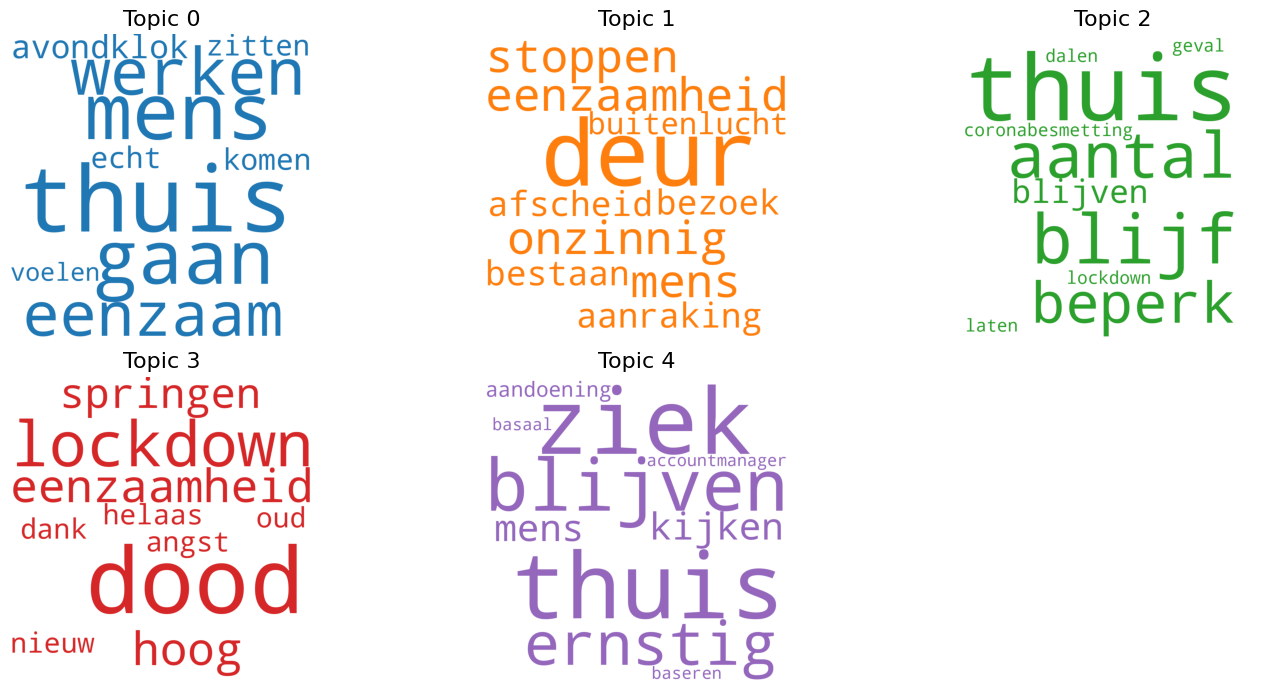

In [27]:
bag_dimension = 15

top_columns = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).index.tolist(), axis=1)
top_scores = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).values.tolist(), axis=1)

dictionaries = [dict(
                    zip(word, [float(value) for value in top_scores_value])
                    )
                    for word, top_scores_value in zip(top_columns, top_scores)]

nested_dictionary = {i:dictionary for i,dictionary in enumerate(dictionaries)}

topic_id = pd.DataFrame(columns=['topic_id'], data=np.arange(0,nested_dictionary.__len__()))

show_topic_wordclouds(df_dominant_topics=topic_id, topics=nested_dictionary)

In [28]:
print_cluster_eval(document_vector_matrx, clustrer_labels)

Silhouette Score: -0.1863754131698668
Silhouette Score: 3.5654479753386195
Silhouette Score: 4.623539454513462


In [29]:
def get_k_neares_words(cluster_centers, any_other_word, k=5):
    from sklearn.neighbors import NearestNeighbors
    assert( cluster_centers.shape[1] == any_other_word.shape[1])
    print("Cluster centers shape:", cluster_centers.shape)
    print("Words2vec shape: ",any_other_word.shape)
    
    # Create and fit the nearest neighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(any_other_word)

    # Find the k nearest neighbors for each point in A
    _, indices = nbrs.kneighbors(cluster_centers)
    return indices

# TODO: cluster the messages using a clustering algorithm

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

clustrer_labels = kmeans.fit_predict(document_vector_matrx)
clustrer_labels.shape, max(clustrer_labels), clustrer_labels


get_k_neares_words(kmeans.cluster_centers_, word_vector_matrx)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AssertionError: 